# **Importing signal**

## Signal info

In [1]:
import mne
import numpy as np

file = "firsttest.edf"
eeg = mne.io.read_raw_edf(f"C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/EEG Data/{file}")

print("\n",eeg.info.keys())
print("\n", eeg.info)

ch = eeg.info["ch_names"] # Channel labels
fs = eeg.info["sfreq"]

print("\nChannel labels: ", ch)

Extracting EDF parameters from C:\Users\migue\OneDrive\Ambiente de Trabalho\Tese\EEG Data\firsttest.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

 dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

 <Info | 7 non-empty values
 bads: []
 ch_names: EEG TP7'', EEG P7'', EEG PO7'', EEG CP5'', EEG P5'', EEG PO5'', ...
 chs: 36 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 269.0 Hz
 meas_date: 2024-02-16 12:39:22 UTC
 nchan: 36
 projs: []
 sfreq: 1024.0 Hz
>

Channel labels:  ["EEG TP7''", "EEG P7''", "EEG PO7''", "

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# Create random data to represent EEG or MEG data
data = np.random.randn(256)

# Create a montage
montage = mne.channels.make_standard_montage('standard_primed')

print(montage.ch_names)

['Fp1', 'Fpz', 'Fp2', "F7'", "F5'", "F3'", "F1'", "Fz'", "F2'", "F4'", "F6'", "F8'", 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', "F7''", "F5''", "F3''", "F1''", "Fz''", "F2''", "F4''", "F6''", "F8''", 'T1', "T3'", "C5'", "C3'", "C1'", "Cz'", "C2'", "C4'", "C6'", "T4'", 'T2', 'T3', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T4', "T3''", "C5''", "C3''", "C1''", "Cz''", "C2''", "C4''", "C6''", "T4''", "T5'", "P5'", "P3'", "P1'", "Pz'", "P2'", "P4'", "P6'", "T6'", "Cb1'", 'T5', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'T6', "Cb2'", 'Cb1', "O1'", "P5''", "P3''", "P1''", "Pz''", "P2''", "P4''", "P6''", "O2'", 'Cb2', 'O1', 'Oz', 'O2', "Cb1''", 'Iz', "Cb2''", 'M1', 'M2', 'A1', 'A2']


## Checking if the recorded signal is an EEG (1/f shape)

### Designing the band pass filter

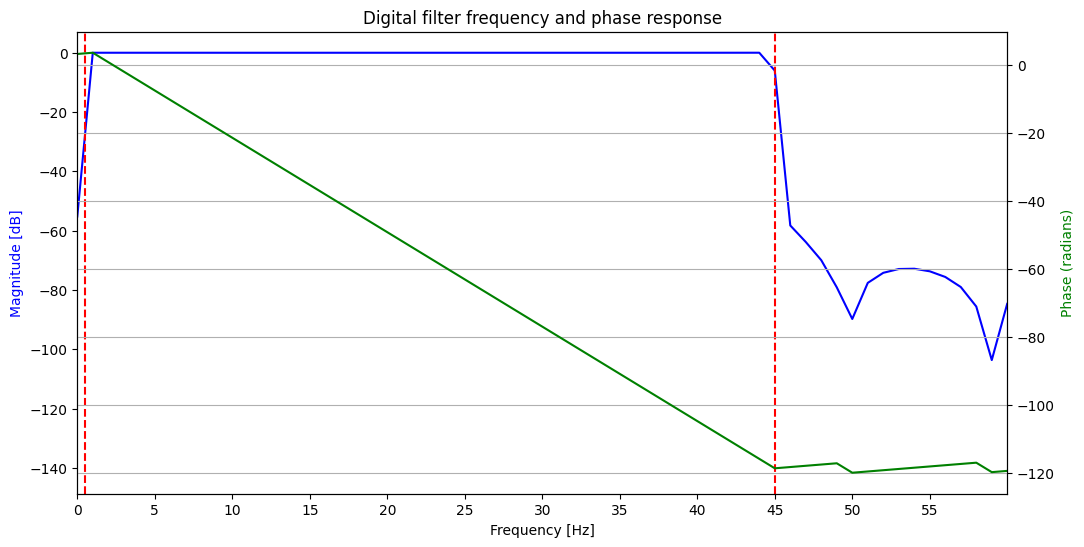

In [49]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import scipy
from scipy.signal import filtfilt, firwin, freqz

# Designing a band-pass FIR filter between 0.5 and 45 Hz
nyquist = fs/2
lowcut = 0.5
highcut = 45
numtaps = 5001 # Order
filt = firwin(numtaps, [lowcut/nyquist, highcut/nyquist], pass_zero=False) 
''' 
pass_zero -> If True, the gain at the frequency 0 (i.e., the “DC gain”) is 1. If False, the DC gain is 0. Can also be a string argument for the desired 
filter type (equivalent to btype in IIR design functions).
'''
# Ploting the frequency response of the filter
w, h = freqz(filt) # The frequency response is returned as a tuple (w, h), where w is the array of frequencies and h is the array of complex coeficients (w: rad/samples)

fig, ax1 = plt.subplots(figsize = (12,6))

ax1.set_title('Digital filter frequency and phase response')
ax1.plot(w*fs/(2*np.pi), 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Magnitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_xticks(np.arange(0,highcut * 4/3, 5))

ax1.axvline(x = lowcut, color = 'r', linestyle = '--')
ax1.axvline(x = highcut, color = 'r', linestyle = '--')

ax2 = ax1.twinx()
ax2.plot(w*fs/(2*np.pi), np.unwrap(np.angle(h)), 'g')
ax2.set_ylabel('Phase (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
ax2.set_xlim(0, highcut * 4/3)

plt.show()

# Applying the filter to the signal using filtfilt
# EEG shape: (33, 231936) = (channels, samples)
eeg_ch_idx = mne.pick_channels(ch, include = [], exclude = ['dc01+', 'dc02+', 'MKR+'])
y = filtfilt(filt, 1, eeg.get_data(picks = eeg_ch_idx), axis = 1)


### Apllying the FFT on the EEG signal

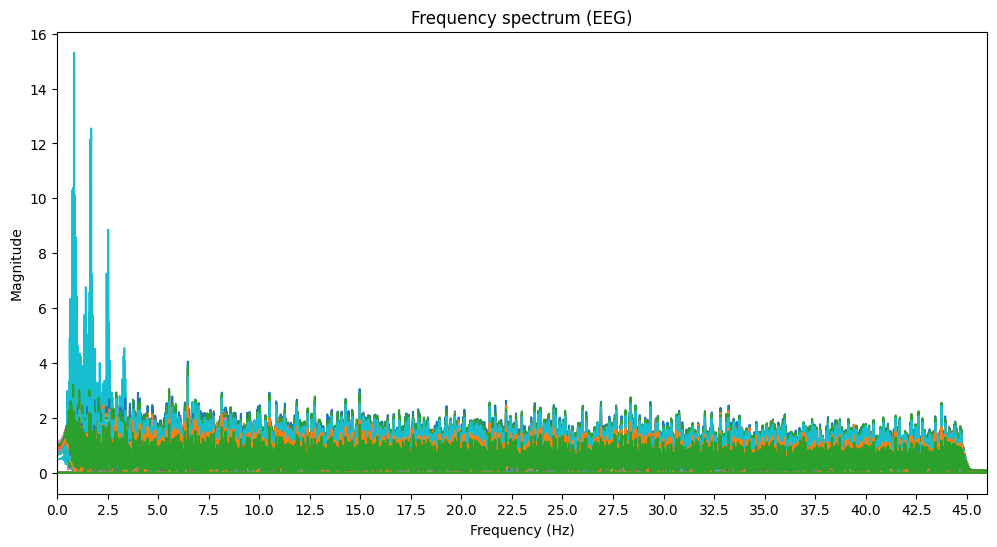

In [50]:
# Compute the FFT of the signal
X = np.fft.fft(y,axis = 1)

# Compute the frequency vector
freqs = np.fft.fftfreq(np.size(X,1), 1/fs)

# Plot the frequency spectrum
figure(figsize = (12,6))
plt.plot(freqs, np.abs(X.T))
plt.title("Frequency spectrum (EEG)")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,highcut + 1)
plt.xticks(np.arange(0,highcut + 1, 2.5)) 
plt.show()

## Isolating the LDR channel

In [51]:
def plot_isolated_signal(time, signal, th, title):
    figure(figsize = (400,20))
    plt.plot(time, signal[:][0], linewidth = 2);
    plt.title(title, fontsize = 100, fontweight = 'bold')
    plt.xlabel('Time (min)', fontsize = 85, fontweight = 'bold')
    plt.ylabel('Voltage (V)', fontsize = 85, fontweight = 'bold')
    plt.xticks(np.arange(0, np.max(time), 0.05), fontsize = 50)
    plt.yticks(np.arange(np.min(signal), np.max(signal), 0.1), fontsize = 50)
    plt.axhline(y = th, color = 'k', linestyle = '--', linewidth = 2)
    plt.grid()

In [52]:
ldr_ch_idx = mne.pick_channels(ch, include = ['dc01+'])
ldr_ch = eeg.get_data(picks = ch[ldr_ch_idx[0]])
if (np.mean(ldr_ch) < 0): # If the polarity was inverted
    print("Inverting signal...")
    ldr_ch = ldr_ch * -1
''' 
The bright square (more light) will decrease the resistance of the LDR, thus producing more voltage
aproximating 2.4V if the polarity of the component was right or -2.4V if the polarity was inverted

The dark square will increase the resistance to the MOhm range and cause the signal to be almost 0.
This is because all the voltage will be sucked by the first component (LDR) of the voltage divider.
'''

time = np.arange(0, np.size(ldr_ch,1)/fs, 1/fs) # Time vector of the acquisition in s
th = 0.3 # y value threshold to segment signal

plot_isolated_signal(time/60, ldr_ch, th, "LDR channel") # time/60 = timevector in minutes

Inverting signal...


## Filtering the LDR channel (Median filter)

In [53]:
filt_ldr_ch = scipy.signal.medfilt(ldr_ch[:][0],201) 
# A 201 points median filter seems to be enough to smooth the signal without causing phase shifts
# The filter applies a zero pad automatically at the edges

plot_isolated_signal(time/60, ldr_ch, th, "Filtered LDR channel")

# **Segmenting the LDR channel**

In [54]:
preStim_offset = -200 # ms | For baseline correction
posStim_offset = 600 
offset = [int(np.floor(preStim_offset * fs/1000)), int(np.floor(posStim_offset * fs/1000))] # fs/1000 = fs in ms

print(f"{posStim_offset} ms = {offset[1]} samples with a sampling frequency of {int(fs)}")

600 ms = 614 samples with a sampling frequency of 1024


In [55]:
def condition_segmentation(ldr, th, offset):
    
    last_low = True
    
    rising_edges = []
    falling_edges = []

    for index, val in enumerate(ldr):

        if val >= th: # Possible rising edge
            if last_low: # Found rising edge
                rising_edges.append(index + offset[0])
                falling_edges.append(index + offset[1] + 1) 
            
            last_low = False
        
        elif val <= th: # Possible falling edge
            last_low = True

    return rising_edges, falling_edges

rising_edges, falling_edges = condition_segmentation(filt_ldr_ch, th, offset)

plot_isolated_signal(time/60, [filt_ldr_ch], th, "Filtered LDR channel with signal segmentation")
for idx, start_sample in enumerate(rising_edges):
    plt.axvline(x = start_sample/fs/60, color = 'g', linestyle = ':', linewidth = 2)
    plt.axvline(x = falling_edges[idx]/fs/60, color = 'r', linestyle = ':', linewidth = 2)
plt.show()

## Segmenting the EEG data

In [56]:
# Picking the EEG channels (https://mne.tools/stable/auto_tutorials/intro/30_info.html#sphx-glr-auto-tutorials-intro-30-info-py)
print("EEG channel indices: ", eeg_ch_idx)
print("\n")

# Looping through all the segmented 
target_eeg_blocks = []
for idx, start_sample in enumerate(rising_edges):
    target_eeg_blocks.append(eeg.get_data(picks = eeg_ch_idx, start = start_sample, stop = falling_edges[idx]))
    print(f"EEG Block {idx + 1} size: {np.shape(target_eeg_blocks[idx])}")

EEG channel indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


EEG Block 1 size: (33, 820)
EEG Block 2 size: (33, 820)
EEG Block 3 size: (33, 820)
EEG Block 4 size: (33, 820)
EEG Block 5 size: (33, 820)
EEG Block 6 size: (33, 820)
EEG Block 7 size: (33, 820)
EEG Block 8 size: (33, 820)
EEG Block 9 size: (33, 820)
EEG Block 10 size: (33, 820)
EEG Block 11 size: (33, 820)
EEG Block 12 size: (33, 820)
EEG Block 13 size: (33, 820)
EEG Block 14 size: (33, 820)
EEG Block 15 size: (33, 820)
EEG Block 16 size: (33, 820)
EEG Block 17 size: (33, 820)
EEG Block 18 size: (33, 820)
EEG Block 19 size: (33, 820)
EEG Block 20 size: (33, 820)
EEG Block 21 size: (33, 820)
EEG Block 22 size: (33, 820)
EEG Block 23 size: (33, 820)
EEG Block 24 size: (33, 820)
EEG Block 25 size: (33, 820)
EEG Block 26 size: (33, 820)
EEG Block 27 size: (33, 820)
EEG Block 28 size: (33, 820)
EEG Block 29 size: (33, 820)
EEG Block 30 size: (33, 820)
EEG Block 31 

## Ploting the grand-average target EEG response

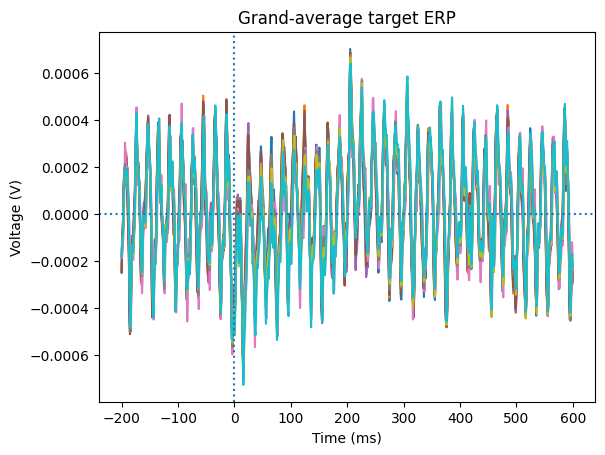

In [57]:
target_erp = np.mean(target_eeg_blocks, axis = 0)
erp_times = np.arange(preStim_offset, posStim_offset, 1000/fs)

plt.plot(erp_times, target_erp[0:10].T);
plt.title("Grand-average target ERP")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.axvline(x = 0, linestyle = ':')
plt.axhline(y = 0, linestyle = ':')